In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline
os.path.append('../../common/')
from common.plot_style_utils import set_pub_plot_context, save_for_pub

In [2]:
set_pub_plot_context(context="paper")
palette = sns.color_palette()
sns.set_style("white")

In [3]:
n_bins = 15 # Number of bins for calibration estimates

In [4]:
seqmeta = np.load("../../../data/results/TEST_100_sub_MLP_full_with_metadata_300300.npy")

In [5]:
seqonly = np.load("../../../data/results/TEST_100_sub_nometadata_201300.npy")

In [6]:
print(seqmeta.shape)
seqonly.shape

(11351, 1314)


(11351, 1314)

In [7]:
true = pickle.load( open( "../../../data/tts/y_test_ord.pkl", "rb" ) )
true

array([ 142.,  142.,  142., ..., 1313., 1313., 1313.])

In [8]:
def acc(pred, true):
    classes = np.argmax(pred, axis=1)
    correct = (classes == true)
    accuracy = np.sum(correct) / len(true)
    return accuracy

def calibration(true, predicted, n_bins):
    """
    Inputs
    true: a vector of indices of the correct class
    predicted: a n_samples x n_labels matrix of softmax probabilities
    n_bins: integer > 0, number of bins to divide the interval [0,1]
    
    Outputs: ECE, MCE, bins, acc_per_bin, conf_per_bin
    """
    true = np.asarray(true,dtype=int)
    bins = np.linspace(0,1, num=n_bins, endpoint=False)
    correct = (np.argmax(predicted,axis=1) == true)

    
    # Above is for the correct, this is max confidence
    prob = np.max(predicted,axis=1)
    
    # Now I need to bin the indices of each.
    binned = np.digitize(prob,bins) - 1 # Returns bin index per row

    accs = []
    confs = []
    for bin_idx in range(n_bins):
        idxs = np.where(binned == bin_idx)
        subset = correct[idxs]
        accuracy = np.sum(subset) / len(subset)
        conf_subset = prob[idxs]
        confidence = np.sum(conf_subset) / len(conf_subset)
        accs.append(accuracy)
        confs.append(confidence)
    diffs = np.abs(np.asarray(accs) - np.asarray(confs))
    diffs = diffs[~np.isnan(diffs)]
    #print(diffs)
    return np.mean(prob), np.mean(diffs), np.max(diffs), bins, accs, confs

In [9]:
acc(seqmeta,true)

0.7005550171791032

In [10]:
acc(seqonly,true)

0.5988899656417936

In [11]:
def topkacc(pred,true,k):
    topkclasses = np.argsort(pred)[:,-k:]
    correct = ((topkclasses == true[:,None]).any(axis=1))
    accuracy = np.sum(correct) / len(true)
    return accuracy

In [12]:
topkacc(seqonly,true,1)

0.5988899656417936

In [13]:
topkacc(seqmeta,true,1)

0.7005550171791032

FOR SEQUENCE ONLY
Top 1 accuracy is 0.5988899656417936
Top 2 accuracy is 0.6852259712800635
Top 3 accuracy is 0.7211699409743635
Top 4 accuracy is 0.7444278037177341
Top 5 accuracy is 0.7600211435115849
Top 6 accuracy is 0.7716500748832702
Top 7 accuracy is 0.7803717734120342
Top 8 accuracy is 0.7902387454849793
Top 9 accuracy is 0.7971984847150031
Top 10 accuracy is 0.8033653422605938
Average confidence:0.6163217425346375
ECE:0.057281973576351966
MCE:0.15466035302005599


/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


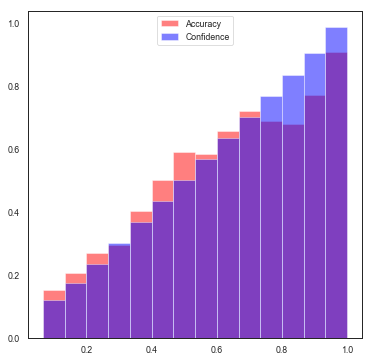

In [14]:
# That works, now check top 10
print("FOR SEQUENCE ONLY")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqonly,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,seqonly,n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color="r", label="Accuracy", alpha=.5)
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color="b", label="Confidence", alpha=.5)
ax.legend()

FOR SEQUENCE AND METADATA
Top 1 accuracy is 0.7005550171791032
Top 2 accuracy is 0.7646903356532464
Top 3 accuracy is 0.7923530966434675
Top 4 accuracy is 0.8091798079464364
Top 5 accuracy is 0.8198396617038146
Top 6 accuracy is 0.8282970663377676
Top 7 accuracy is 0.8334948462690512
Top 8 accuracy is 0.8383402343405867
Top 9 accuracy is 0.8426570346225002
Top 10 accuracy is 0.8474143247290987
Average confidence:0.75801682472229
ECE:0.04766391991022291
MCE:0.08967013888888897
mkdir: cannot create directory ‘../data/manuscript/figs/2/’: File exists


/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


mkdir: cannot create directory ‘../data/manuscript/figs/2/a’: File exists


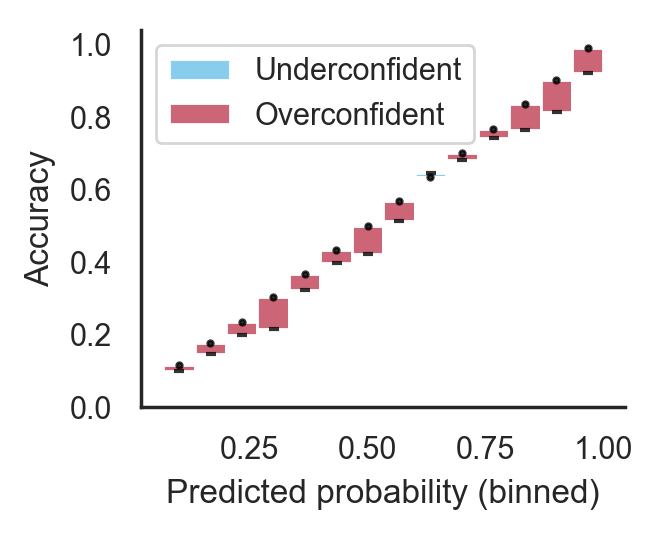

In [15]:
print("FOR SEQUENCE AND METADATA")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqmeta,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,seqmeta,n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(2.5,2), dpi=250)
ax = fig.add_subplot(111,
                    xlabel="Predicted probability (binned)",
                     ylabel="Accuracy"
                    )
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color=palette[0], label="Underconfident")
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color=palette[1], label="Overconfident")
whiteout = [acc[i] if acc[i] < conf[i] else conf[i] for i in range(len(acc)) ]
ax.bar(left=bins, height=whiteout, align="edge", width=1/len(bins), color="w", alpha=1)


ax.legend()
# The hline is not centered by default (hence adding the small val).
ax.scatter(bins+((1/n_bins)/2)+.0009,acc,c="black", s=10, marker="_", alpha=.8, zorder=1000000)
ax.scatter(bins+((1/n_bins)/2),conf,c="black", s=10, marker=".", alpha=.8, zorder=1000000)
sns.despine()
!mkdir ../../../data/manuscript/figs/2/
!mkdir ../../../data/manuscript/figs/2/a
save_for_pub(fig, path="../../../data/manuscript/figs/2/a/v0", dpi=500)

NIELSEN AND VOIGT
Top 1 accuracy is 0.5025988899656418
Top 2 accuracy is 0.5887586996740375
Top 3 accuracy is 0.6350982292309048
Top 4 accuracy is 0.6626728922561889
Top 5 accuracy is 0.6830235221566382
Top 6 accuracy is 0.6979120782309929
Top 7 accuracy is 0.7091886177429302
Top 8 accuracy is 0.7188793938860012
Top 9 accuracy is 0.7276891903797023
Top 10 accuracy is 0.734648929609726
Average confidence:0.607609212398529
ECE:0.1127005200784581
MCE:0.17385486990322824


/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


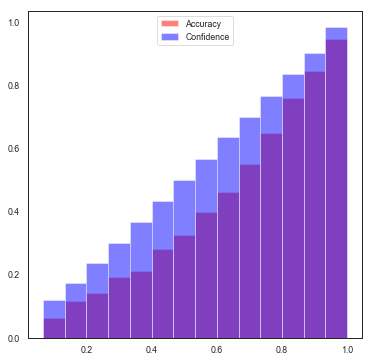

In [24]:
seqonly = np.load("../../../data/CNN/TEST_LOGITS_nv_787800.npy")

# That works, now check top 10
print("NIELSEN AND VOIGT")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqonly,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,sp.special.softmax(seqonly,axis=-1),n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color="r", label="Accuracy", alpha=.5)
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color="b", label="Confidence", alpha=.5)
ax.legend()